<a href="https://colab.research.google.com/github/yukinaga/image_classification/blob/main/section_3/02_googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogLeNetの実装
PyTorchを使って、GoogLeNetを実装します。  
torchvisionには訓練済みのGoogLeNetがあるので、これを読み込んだ上で一部の層をタスクに合わせて入れ替えます。  
学習に時間がかかるので、「編集」→「ノートブックの設定」の「ハードウェアアクセラレーター」で「GPU」を選択しましょう。  

## データの前処理
入力画像は、GoogLeNetに合わせてサイズが224の正方形に変換します。  
以下の行でRGBの各値の平均値と標準偏差を設定しますが、これらの設定値はImageNetによる学習済みモデルの設定値で、PyTorchの公式ドキュメントを参考にしています。    

```
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
```
  
GoogLeNet（PyTorch）: https://pytorch.org/hub/pytorch_vision_googlenet/



In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),  # 短い方の辺を256に
    transforms.CenterCrop(224),  # 辺の長さが224の正方形を中央から切り抜く
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの読み込み
torchvisionを使い、GoogLeNetの訓練済みモデルを読み込みます。  
https://pytorch.org/vision/stable/generated/torchvision.models.googlenet.html  
`pretrained=True`と設定することで、パラメータが訓練済みとなります。  

In [2]:
import torchvision.models as models

net = models.googlenet(pretrained=True, aux_logits=True, transform_input=False)
print(net)

c:\Users\nishi\Projects\image_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nishi\Projects\image_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\nishi/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100.0%
c:\Users\nishi\Projects\image_classification\.venv\Lib\site-packages\torchvision\models\googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet mod

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 各層の設定
分類器として機能する全結合層を、10クラス分類に合わせて入れ替えます。  
今回は特徴抽出に用いた箇所は追加で訓練を行わず、分類器のみ訓練します。  


In [3]:
import torch.nn as nn

# 全ての層のパラメータを訓練不可に
for param in net.parameters():
    param.requires_grad = False

# 補助の分類器 (Auxiliary Classifier) の出力層を入れ替え（デフォルトで訓練可能）
net.aux1.fc2 = nn.Linear(1024,10)
net.aux2.fc2 = nn.Linear(1024,10)

# 最後の出力層を入れ替え（デフォルトで訓練可能）
net.fc = nn.Linear(1024,10)

net.cuda()  # GPU対応
print(net)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  

In [4]:
from typing import NewType
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(6):  # 6エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss_main = loss_fnc(y[0], t)  # 最後の出力層の損失
        loss_aux1 = loss_fnc(y[1], t)  # 補助の分類器の損失
        loss_aux2 = loss_fnc(y[2], t)  # 補助の分類器の損失
        loss = loss_main + 0.3*loss_aux1 + 0.3*loss_aux2
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.9136747972434744 Loss_Test: 0.7303764949178999
Epoch: 1 Loss_Train: 1.5952754381977383 Loss_Test: 0.6913495504172744
Epoch: 2 Loss_Train: 1.559802531128954 Loss_Test: 0.6834258532068532
Epoch: 3 Loss_Train: 1.5397152888500476 Loss_Test: 0.6450348103501994
Epoch: 4 Loss_Train: 1.544624954233389 Loss_Test: 0.6442086296096728
Epoch: 5 Loss_Train: 1.5350605709778378 Loss_Test: 0.643104661232347


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

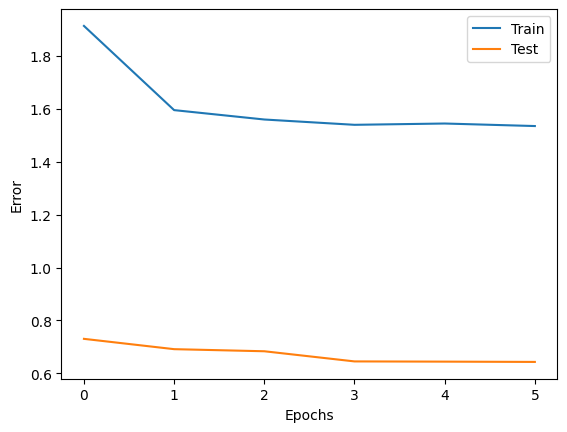

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [6]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 77.79%
